## Importing Libraries

In [ ]:
!python -m pip install transformers
!python -m pip install Sastrawi
!python -m pip install xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from Sastrawi.Dictionary.ArrayDictionary import ArrayDictionary
from Sastrawi.StopWordRemover.StopWordRemover import StopWordRemover
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

plt.style.use('ggplot')
np.__version__

'1.22.4'

## Loading the data

In [ ]:
!gdown 1EgJ4xUZeNzzCMjRe4Y5c1rTsmhWLD8lL
!gdown 1bSIqET2ZpqwonIygZP8IEh49yFJ170yD

Downloading...
From: https://drive.google.com/uc?id=1EgJ4xUZeNzzCMjRe4Y5c1rTsmhWLD8lL
To: /content/Symptom2DiseaseID.csv
100% 240k/240k [00:00<00:00, 166MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bSIqET2ZpqwonIygZP8IEh49yFJ170yD
To: /content/Converted DS Dataset-revised-v2.csv
100% 1.59M/1.59M [00:00<00:00, 186MB/s]


In [ ]:
dfNLP = pd.read_csv('./Symptom2DiseaseID.csv', delimiter=';')
dfNLP.drop("indeks", axis=1, inplace=True)
dfNLP.head()

,label,text
0,Psoriasis,"Saya telah mengalami ruam kulit di lengan, ka..."
1,Psoriasis,"Kulit saya mengelupas, terutama di lutut, sik..."
2,Psoriasis,"Saya telah mengalami nyeri sendi di jari, per..."
3,Psoriasis,"Ada debu seperti perak di kulit saya, terutam..."
4,Psoriasis,Kuku saya memiliki penyok atau lubang kecil d...


In [ ]:
dfCnv = pd.read_csv('./Converted DS Dataset-revised-v2.csv', delimiter=';')
# dfCnv.drop("Unnamed: 0", axis=1, inplace=True)
dfCnv.head()

,symptoms,prognosa
0,Saya mengalami ruam kulit dalam beberapa hari ...,19
1,Saya mengalami erupsi kulit nodal dalam bebera...,19
2,Saya mengalami erupsi kulit nodal dalam bebera...,19
3,Saya mengalami gatal dalam beberapa hari terak...,19
4,Saya mengalami ruam kulit dalam beberapa hari ...,19


In [ ]:
dfNLP.label = dfNLP.label.str.replace('^ +| +$', '', regex=True)
dfNLP['label'] = dfNLP['label'].replace({'Pembuluh mekar':'Varises', 'Wasir Dimorfik' : 'Wasir', 'spondylosis serviks':'Spondylosis'})
dfNLP['label'] = dfNLP['label'].str.title()
dfCnv.rename(columns={'symptoms': 'text', 'prognosa': 'label'}, inplace=True)
dfCnv = dfCnv[dfCnv.columns[::-1]]

In [ ]:
indextolabel = {
    0: 'Vertigo Posisi Paroymsal',
    1: 'AIDS',
    2: 'Alergi',
    3: 'Asma Bronkial',
    4: 'Cacar Air',
    5: 'Diabetes',
    6: 'Flu Biasa',
    7: 'GERD',
    8: 'Gastroenteritis',
    9: 'Hepatitis B',
    10: 'Hepatitis C',
    11: 'Hepatitis D',
    12: 'Hepatitis E',
    13: 'Hepatitis Alkoholik',
    14: 'Hipertensi',
    15: 'Hipertiroidisme',
    16: 'Hipoglikemia',
    17: 'Hipotiroidisme',
    18: 'Impetigo',
    19: 'Infeksi Jamur',
    20: 'Infeksi Saluran Kemih',
    21: 'Jerawat',
    22: 'Pendarahan Otak',
    23: 'Malaria',
    24: 'Migrain',
    25: 'Osteoartritis',
    26: 'Varises',
    27: 'Penyakit Kuning',
    28: 'Penyakit Tipus',
    29: 'Penyakit Ulkus Peptikum',
    30: 'Psoriasis',
    31: 'Radang Paru-Paru',
    32: 'Radang Sendi',
    33: 'Reaksi Obat',
    34: 'Serangan Jantung',
    35: 'TBC',
    36: 'Wasir',
    37: 'Demam Berdarah',
    38: 'hepatitis A',
    39: 'kolestasis Kronis',
    40: 'Spondylosis',
}

dfCnv['label'] = dfCnv['label'].replace(indextolabel)

In [ ]:
dfNLP['label'].value_counts()

Psoriasis                          50
Varises                            50
Penyakit Ulkus Peptikum            50
Reaksi Obat                        50
Penyakit Refluks Gastroesofagus    50
Alergi                             50
Infeksi Saluran Kemih              50
Malaria                            50
Penyakit Kuning                    50
Spondylosis                        50
Migrain                            50
Hipertensi                         50
Asma Bronkial                      50
Jerawat                            50
Radang Sendi                       50
Wasir                              50
Radang Paru-Paru                   50
Flu Biasa                          50
Infeksi Jamur                      50
Demam Berdarah                     50
Impetigo                           50
Cacar Air                          50
Penyakit Tipus                     50
Diabetes                           50
Name: label, dtype: int64

In [ ]:
dfCnv['label'].value_counts()

Infeksi Jamur               120
Hepatitis C                 120
Hepatitis E                 120
Hepatitis Alkoholik         120
TBC                         120
Flu Biasa                   120
Radang Paru-Paru            120
Wasir                       120
Serangan Jantung            120
Varises                     120
Hipotiroidisme              120
Hipertiroidisme             120
Hipoglikemia                120
Osteoartritis               120
Radang Sendi                120
Vertigo Posisi Paroymsal    120
Jerawat                     120
Infeksi Saluran Kemih       120
Psoriasis                   120
Hepatitis D                 120
Hepatitis B                 120
Alergi                      120
hepatitis A                 120
GERD                        120
kolestasis Kronis           120
Reaksi Obat                 120
Penyakit Ulkus Peptikum     120
AIDS                        120
Diabetes                    120
Gastroenteritis             120
Asma Bronkial               120
Hiperten

In [ ]:
dfMerge = pd.concat([dfCnv, dfNLP], ignore_index=True)

In [ ]:
dfMerge.head()

,label,text
0,Infeksi Jamur,Saya mengalami ruam kulit dalam beberapa hari ...
1,Infeksi Jamur,Saya mengalami erupsi kulit nodal dalam bebera...
2,Infeksi Jamur,Saya mengalami erupsi kulit nodal dalam bebera...
3,Infeksi Jamur,Saya mengalami gatal dalam beberapa hari terak...
4,Infeksi Jamur,Saya mengalami ruam kulit dalam beberapa hari ...


In [ ]:
for nama_kolom in dfMerge.columns:
  print(dfMerge[nama_kolom].value_counts(), "\n")

Infeksi Jamur                      170
Spondylosis                        170
Radang Paru-Paru                   170
Flu Biasa                          170
Varises                            170
Alergi                             170
Radang Sendi                       170
Penyakit Tipus                     170
Demam Berdarah                     170
Cacar Air                          170
Malaria                            170
Penyakit Kuning                    170
Migrain                            170
Infeksi Saluran Kemih              170
Impetigo                           170
Psoriasis                          170
Reaksi Obat                        170
Penyakit Ulkus Peptikum            170
Wasir                              170
Diabetes                           170
Jerawat                            170
Asma Bronkial                      170
Hipertensi                         170
Vertigo Posisi Paroymsal           120
Hipoglikemia                       120
Hipertiroidisme          

In [ ]:
import itertools
factory = StopWordRemoverFactory()

addStopwords = ['saya', 'saya.', 'itu', 'itu,', 'juga']
removeStopwords = ['atau', 'dalam', 'dan', 'dari', 'di', 'pada', 'ke', 'saat','sekitar', 'seperti', 'tidak', 'yang']

stopWords = factory.get_stop_words()+addStopwords

for removeStopword in removeStopwords:
    if removeStopword in stopWords:
        stopWords.remove(removeStopword)
    else:
        continue

dictionaryWord = ArrayDictionary(stopWords)
stopWordRemover = StopWordRemover(dictionaryWord)

for i in range(len(dfMerge["text"])):
    dfMerge["text"][i] = dfMerge["text"][i].lstrip()
    dfMerge["text"][i] = re.sub('  +', ' ', dfMerge["text"][i])
    dfMerge["text"][i] = re.sub(r'[^\x00-\x7f]','r', dfMerge["text"][i])
    dfMerge["text"][i] = dfMerge["text"][i].encode('ascii', 'ignore').decode('utf-8')
    dfMerge["text"][i] = ''.join(''.join(s)[:1] for _, s in itertools.groupby(dfMerge["text"][i]))
    dfMerge["text"][i] = dfMerge["text"][i].lower()
    dfMerge["text"][i] = stopWordRemover.remove(dfMerge["text"][i])
    dfMerge["label"][i] = dfMerge["label"][i].lower()
    dfMerge["label"][i] = dfMerge["label"][i].title()

dfMerge.label = dfMerge.label.str.replace('^ +| +$', '', regex=True)

In [ ]:
dfMerge.head()

,label,text
0,Infeksi Jamur,mengalami ruam kulit dalam beberapa hari terak...
1,Infeksi Jamur,mengalami erupsi kulit nodal dalam beberapa ha...
2,Infeksi Jamur,mengalami erupsi kulit nodal dalam beberapa ha...
3,Infeksi Jamur,mengalami gatal dalam beberapa hari terakhir. ...
4,Infeksi Jamur,mengalami ruam kulit dalam beberapa hari terak...


In [ ]:
# df_sampel = pd.concat([dfMerge[dfMerge['label'] == kelas].sample(n=50, random_state=42) for kelas in dfMerge['label'].unique() if kelas not in ['Pembuluh Mekar', 'Wasir Dimorfik', 'Penyakit Refluks Gastroesofagus']])
# dfMerge = pd.concat([dfMerge[dfMerge['label'].isin(['Pembuluh Mekar', 'Wasir Dimorfik', 'Penyakit Refluks Gastroesofagus'])], df_sampel])

In [ ]:
for nama_kolom in dfMerge.columns:
  print(dfMerge[nama_kolom].value_counts(), "\n")

Infeksi Jamur                      170
Spondylosis                        170
Radang Paru-Paru                   170
Flu Biasa                          170
Varises                            170
Alergi                             170
Radang Sendi                       170
Penyakit Tipus                     170
Demam Berdarah                     170
Cacar Air                          170
Malaria                            170
Penyakit Kuning                    170
Migrain                            170
Infeksi Saluran Kemih              170
Impetigo                           170
Psoriasis                          170
Reaksi Obat                        170
Penyakit Ulkus Peptikum            170
Wasir                              170
Diabetes                           170
Jerawat                            170
Asma Bronkial                      170
Hipertensi                         170
Vertigo Posisi Paroymsal           120
Hipoglikemia                       120
Hipertiroidisme          

Creating encodings for disease.

In [ ]:
int2label = {}

for i, disease in enumerate(dfMerge['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

int2label, label2int

({0: 'Infeksi Jamur',
  1: 'Alergi',
  2: 'Gerd',
  3: 'Kolestasis Kronis',
  4: 'Reaksi Obat',
  5: 'Penyakit Ulkus Peptikum',
  6: 'Aids',
  7: 'Diabetes',
  8: 'Gastroenteritis',
  9: 'Asma Bronkial',
  10: 'Hipertensi',
  11: 'Migrain',
  12: 'Spondylosis',
  13: 'Pendarahan Otak',
  14: 'Penyakit Kuning',
  15: 'Malaria',
  16: 'Cacar Air',
  17: 'Demam Berdarah',
  18: 'Penyakit Tipus',
  19: 'Hepatitis A',
  20: 'Hepatitis B',
  21: 'Hepatitis C',
  22: 'Hepatitis D',
  23: 'Hepatitis E',
  24: 'Hepatitis Alkoholik',
  25: 'Tbc',
  26: 'Flu Biasa',
  27: 'Radang Paru-Paru',
  28: 'Wasir',
  29: 'Serangan Jantung',
  30: 'Varises',
  31: 'Hipotiroidisme',
  32: 'Hipertiroidisme',
  33: 'Hipoglikemia',
  34: 'Osteoartritis',
  35: 'Radang Sendi',
  36: 'Vertigo Posisi Paroymsal',
  37: 'Jerawat',
  38: 'Infeksi Saluran Kemih',
  39: 'Psoriasis',
  40: 'Impetigo',
  41: 'Penyakit Refluks Gastroesofagus'},
 {'Infeksi Jamur': 0,
  'Alergi': 1,
  'Gerd': 2,
  'Kolestasis Kronis': 3,
 

## Data Distribution

Text(0.5, 1.0, 'Jumlah Data untuk masing-masing penyakit')

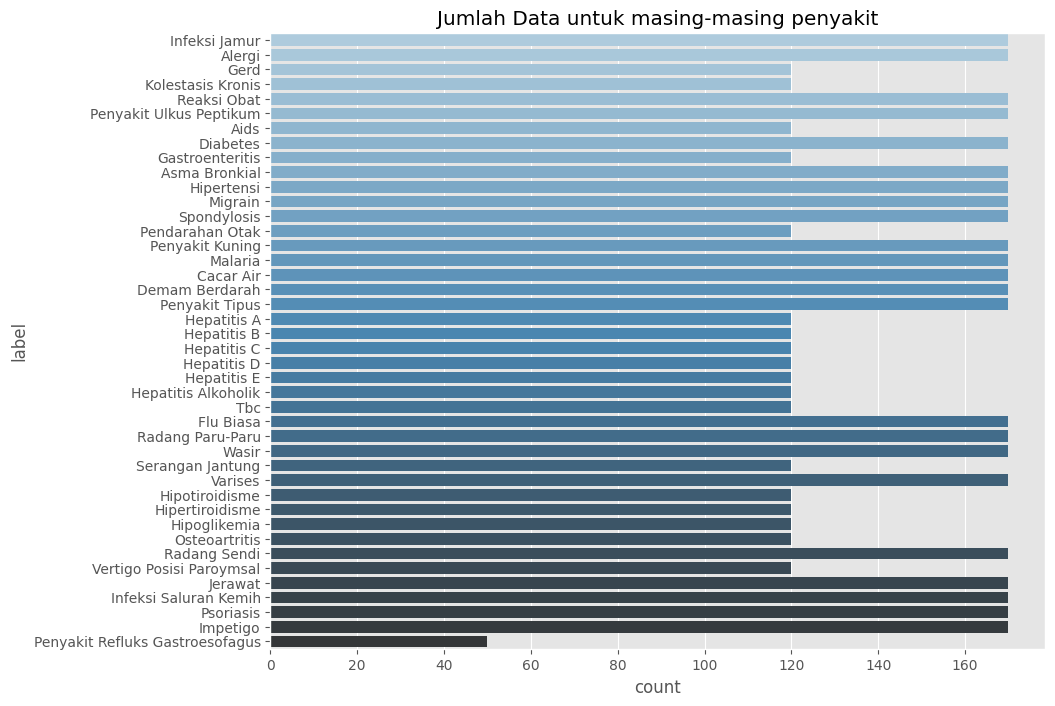

In [ ]:
plt.figure(figsize = (10, 8))

sea.countplot(y = dfMerge['label'], palette = 'Blues_d')
plt.title('Jumlah Data untuk masing-masing penyakit')

## Distribution of the lenght of description

  0%|          | 0/6120 [00:00<?, ?it/s]

Max Length is :  55


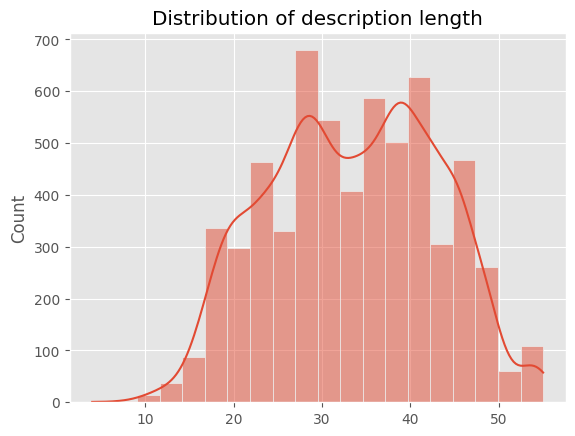

In [ ]:
length = []
for txt in tqdm(dfMerge['text'].values):
    length.append(len(txt.split()))

sea.histplot(length, kde = True, bins = 20)
plt.title('Distribution of description length')
print("Max Length is : ", max(length))

In [ ]:
dfMerge['label'] = dfMerge['label'].map(lambda x : label2int[x])

In [ ]:
X, y = dfMerge['text'].values, dfMerge['label'].values

x_tokenizer = Tokenizer(filters = '')
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 1801


## Creating the train and testing data

In [ ]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((5508,), (612,), (5508,), (612,))

In [ ]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("cahya/bert-base-indonesian-522M")
train_encodings = tokenizer(list(train_x), max_length=512, padding='max_length', truncation=True)
val_encodings = tokenizer(list(val_x), max_length=512, padding='max_length', truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)


In [ ]:
num_classes = 42

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "cahya/bert-base-indonesian-522M", 
    num_labels = num_classes, 
    id2label = int2label, 
    label2id = label2int,
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['accuracy'])

model

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7fd8481e6fe0> True
<keras.layers.regularization.dropout.Dropout object at 0x7fd84814d0f0> True
<keras.layers.core.dense.Dense object at 0x7fd84814d4e0> True


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  32298     
                                                                 
Total params: 110,649,642
Trainable params: 110,649,642
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 10
batch_size = 16

history = model.fit(train_dataset,
          batch_size=batch_size,
          epochs = EPOCHS,
          validation_data = val_dataset)

Epoch 1/10
689/689 [==============================] - 705s 942ms/step - loss: 0.7707 - accuracy: 0.8807 - val_loss: 0.1307 - val_accuracy: 0.9771
Epoch 2/10
689/689 [==============================] - 661s 959ms/step - loss: 0.0632 - accuracy: 0.9918 - val_loss: 0.0679 - val_accuracy: 0.9886
Epoch 3/10
689/689 [==============================] - 645s 935ms/step - loss: 0.0183 - accuracy: 0.9984 - val_loss: 0.0382 - val_accuracy: 0.9902
Epoch 4/10
689/689 [==============================] - 645s 936ms/step - loss: 0.0172 - accuracy: 0.9980 - val_loss: 0.0376 - val_accuracy: 0.9935
Epoch 5/10
689/689 [==============================] - 645s 937ms/step - loss: 0.0245 - accuracy: 0.9971 - val_loss: 0.0680 - val_accuracy: 0.9837
Epoch 6/10
689/689 [==============================] - 644s 935ms/step - loss: 0.0471 - accuracy: 0.9907 - val_loss: 0.0427 - val_accuracy: 0.9918
Epoch 7/10
689/689 [==============================] - 644s 935ms/step - loss: 0.0158 - accuracy: 0.9966 - val_loss: 0.0400 -

In [ ]:
model.evaluate(val_dataset, batch_size=batch_size)

77/77 [==============================] - 25s 327ms/step - loss: 0.0364 - accuracy: 0.9918


[0.03635048866271973, 0.991830050945282]

## Plotting the loss and accuracy plot.

In [ ]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()

## Testing the model on custom input.

In [ ]:
path = "./model_merge_bert_multilungual_v6"
path2 = "./tokenizer_merge_bert_multilungual_v6"
model.save_pretrained(path)
tokenizer.save_pretrained(path2)

('./tokenizer_merge_bert_multilungual_v6/tokenizer_config.json',
 './tokenizer_merge_bert_multilungual_v6/special_tokens_map.json',
 './tokenizer_merge_bert_multilungual_v6/vocab.txt',
 './tokenizer_merge_bert_multilungual_v6/added_tokens.json',
 './tokenizer_merge_bert_multilungual_v6/tokenizer.json')

In [ ]:
!zip -r model_merge_bert_multilungual_v6.zip "/content/model_merge_bert_multilungual_v6"

  adding: content/model_merge_bert_multilungual_v6/ (stored 0%)
  adding: content/model_merge_bert_multilungual_v6/config.json (deflated 61%)
  adding: content/model_merge_bert_multilungual_v6/tf_model.h5 (deflated 7%)


In [ ]:
!zip -r tokenizer_merge_bert_multilungual_v6.zip "/content/tokenizer_merge_bert_multilungual_v6"

  adding: content/tokenizer_merge_bert_multilungual_v6/ (stored 0%)
  adding: content/tokenizer_merge_bert_multilungual_v6/tokenizer_config.json (deflated 47%)
  adding: content/tokenizer_merge_bert_multilungual_v6/special_tokens_map.json (deflated 42%)
  adding: content/tokenizer_merge_bert_multilungual_v6/vocab.txt (deflated 51%)
  adding: content/tokenizer_merge_bert_multilungual_v6/tokenizer.json (deflated 71%)


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, BertModel

In [ ]:
tokenizerlocal = BertTokenizer.from_pretrained("./tokenizer_merge_bert_multilungual_v6", local_files_only=True)

In [ ]:
modellocal = BertForSequenceClassification.from_pretrained("./model_merge_bert_multilungual_v6", from_tf=True)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=modellocal, tokenizer=tokenizerlocal, top_k = 24)

text1 = str(" Penglihatan saya berkabut, dan tampaknya semakin memburuk. Saya merasa lelah dan lelah sepanjang waktu. Saya juga sering mengalami pusing parah dan pusing.").lower()
text2 = str("Saya mengalami sembelit dan sakit perut, dan itu sangat tidak nyaman. Sakit perut semakin parah dan mulai mempengaruhi kehidupan sehari-hari saya. Apalagi setiap malam saya menggigil, diikuti demam ringan.").lower()
text3 = str(" saya merasa sangat gatal, sakit, dan lelah. selain itu, berat badan saya turun dan suhu tubuh saya naik. urine saya berwarna gelap, dan kulit saya menjadi kuning. selain itu, saya juga mengalami sakit perut.").lower()

pred1 = pipe(text1)
pred2 = pipe(text2)
pred3 = pipe(text3)

print(pred1[0][:2])
print(pred2[0][:2])
print(pred3[0][:2])

[{'label': 'Diabetes', 'score': 0.9974272847175598}, {'label': 'Reaksi Obat', 'score': 0.0008538312977179885}]
[{'label': 'Penyakit Tipus', 'score': 0.9986407160758972}, {'label': 'Penyakit Ulkus Peptikum', 'score': 0.00014719706086907536}]
[{'label': 'Penyakit Kuning', 'score': 0.9992955923080444}, {'label': 'Radang Paru-Paru', 'score': 0.00010148355067940429}]


In [ ]:
factory = StopWordRemoverFactory()
addStopwords = ['juga', 'itu', 'saya']
removeStopwords = ['namun', 'tidak', 'setelah', 'masih', 'dengan', "merasakan", "adanya", "ada"]
stopWords = factory.get_stop_words()+addStopwords

for removeStopword in removeStopwords:
    if removeStopword in stopWords:
        stopWords.remove(removeStopword)
    else:
        continue

dictionaryWord = ArrayDictionary(stopWords)
stopWordRemover = StopWordRemover(dictionaryWord)

def preprocessing_user_input(text):
    global stopWordRemover

    text = re.sub('  +', ' ', text)
    text = re.sub(r'[^\x00-\x7f]','r', text)
    text = text.encode('ascii', 'ignore').decode('utf-8')
    text = ''.join(''.join(s)[:1] for _, s in itertools.groupby(text))
    text = text.lstrip()
    text = text.lower()
    text = stopWordRemover.remove(text)

    return text

In [ ]:
%%time
text1 = str(" Penglihatan saya berkabut, dan tampaknya semakin memburuk. Saya merasa lelah dan lelah sepanjang waktu. Saya juga sering mengalami pusing parah dan pusing.").lower()
text2 = str("Saya mengalami sembelit dan sakit perut, dan itu sangat tidak nyaman. Sakit perut semakin parah dan mulai mempengaruhi kehidupan sehari-hari saya. Apalagi setiap malam saya menggigil, diikuti demam ringan.").lower()
text3 = str(" saya merasa sangat gatal, sakit, dan lelah. selain itu, berat badan saya turun dan suhu tubuh saya naik. urine saya berwarna gelap, dan kulit saya menjadi kuning. selain itu, saya juga mengalami sakit perut.").lower()

pred1 = pipe(text1)
pred2 = pipe(text2)
pred3 = pipe(text3)

print(pred1[0][:2])
print(pred2[0][:2])
print(pred3[0][:2])

[{'label': 'Diabetes', 'score': 0.9974272847175598}, {'label': 'Reaksi Obat', 'score': 0.0008538312977179885}]
[{'label': 'Penyakit Tipus', 'score': 0.9986407160758972}, {'label': 'Penyakit Ulkus Peptikum', 'score': 0.00014719706086907536}]
[{'label': 'Penyakit Kuning', 'score': 0.9992955923080444}, {'label': 'Radang Paru-Paru', 'score': 0.00010148355067940429}]
CPU times: user 462 ms, sys: 323 µs, total: 463 ms
Wall time: 467 ms


In [ ]:
%%time
text1 = " Penglihatan saya berkabut, dan tampaknya semakin memburuk. Saya merasa lelah dan lelah sepanjang waktu. Saya juga sering mengalami pusing parah dan pusing."
text2 = "Saya mengalami sembelit dan sakit perut, dan itu sangat tidak nyaman. Sakit perut semakin parah dan mulai mempengaruhi kehidupan sehari-hari saya. Apalagi setiap malam saya menggigil, diikuti demam ringan."
text3 = " saya merasa sangat gatal, sakit, dan lelah. selain itu, berat badan saya turun dan suhu tubuh saya naik. urine saya berwarna gelap, dan kulit saya menjadi kuning. selain itu, saya juga mengalami sakit perut."

pred1 = pipe(preprocessing_user_input(text1))
pred2 = pipe(preprocessing_user_input(text2))
pred3 = pipe(preprocessing_user_input(text3))

print(pred1[0][:2])
print(pred2[0][:2])
print(pred3[0][:2])

[{'label': 'Diabetes', 'score': 0.9979953765869141}, {'label': 'Reaksi Obat', 'score': 0.0006259650690481067}]
[{'label': 'Penyakit Tipus', 'score': 0.9988681077957153}, {'label': 'Penyakit Ulkus Peptikum', 'score': 9.743473492562771e-05}]
[{'label': 'Penyakit Kuning', 'score': 0.9994640946388245}, {'label': 'Radang Paru-Paru', 'score': 5.708999015041627e-05}]
CPU times: user 420 ms, sys: 0 ns, total: 420 ms
Wall time: 428 ms


In [ ]:
pred1 = pipe(preprocessing_user_input("saya sepertinya sakit"))

print(pred1[0][:2])

[{'label': 'Cacar Air', 'score': 0.4044741690158844}, {'label': 'Hepatitis C', 'score': 0.3164357542991638}]


In [ ]:
!ls -lh tokenizer_merge_bert_multilungual_v6.zip model_merge_bert_multilungual_v6.zip

-rw-r--r-- 1 root root 392M Jun  4 22:16 model_merge_bert_multilungual_v6.zip
-rw-r--r-- 1 root root 319K Jun  4 22:16 tokenizer_merge_bert_multilungual_v6.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r tokenizer_merge_bert_multilungual_v6.zip "/content/drive/My Drive/Save Model Capstone/"

In [ ]:
!cp -r model_merge_bert_multilungual_v6.zip "/content/drive/My Drive/Save Model Capstone/"

In [ ]:
dfMerge.to_csv('data_merge_nlp-csv_clean_v6.csv', index = False, header = True, index_label = None)
!cp -r data_merge_nlp-csv_clean_v6.csv "/content/drive/My Drive/Save Model Capstone/"